In [1]:
import os
import matplotlib.pyplot as plt
from gym_minigrid.wrappers import *
from gym.wrappers import *
import rl_representation as rl
from rl_representation.src.models import FTA
from rl_representation.src.envs.simulation import train_task_model
import torch
from torch import nn
import numpy as np
import copy
import wandb
import seaborn as sns

from env_helpers import *
from utils import *
from training import *

os.environ['WANDB_MODE'] = 'offline'
wandb.init()

%matplotlib inline
sns.set()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Shape: (1200,) => 1200


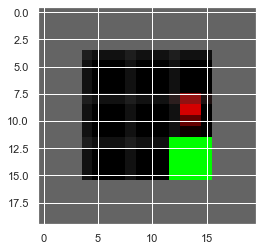

In [2]:
def make_env(color_shift=None, shift_strength=0.3):
    env = GridEnv(size=5) # gym.make('MiniGrid-Empty-Random-6x6-v0')
    env = RGBImgObsWrapper(env) # Get pixel observations
    env = ImgObsWrapper(env) # Get rid of the 'mission' field
    if color_shift:
        env = ColorShiftWrapper(env, color_shift, shift_strength)
    env = SimplifyObsWrapper(env, False, scale_factor=0.5) # Downscale and grayscale
    env = FlattenObservations(env)
    return env
    
env = make_env()
obs = env.reset() # This now produces an RGB tensor only

IMG_SHAPE = (3, 20, 20)
print('Shape:', obs.shape, '=>', np.prod(obs.shape))
plt.imshow(obs.reshape(IMG_SHAPE).transpose(1, 2, 0))

In [3]:
class ValueNetwork(nn.Module):
    def __init__(self, obs_dim, n_acts, encoder, hidden_size=128):
        super().__init__()
        self.encoder = encoder

        test_input = torch.zeros(1, *obs_dim)
        with torch.no_grad():
            self.encoder_output_size = encoder(test_input).view(-1).shape[0]

        fta = FTA(hidden_size)
        self.value_layers = nn.Sequential(
            self.encoder,
            nn.Flatten(),
            nn.Linear(self.encoder_output_size, hidden_size),
            fta,
            nn.Linear(hidden_size * fta.n_tiles, n_acts, bias=False))

        self._init_weights()

    def _init_weights(self):
        self.value_layers[-1].weight.data.fill_(0)
        # self.value_layers[-1].bias.data.fill_(0)

    def forward(self, x):
        return self.value_layers(x)

In [4]:
device = 'cuda'

hidden_size = 128
def create_agent():
    encoder = nn.Sequential(
        nn.Flatten(),
        nn.Linear(np.prod(obs.shape), 100),
        nn.ReLU())
    model = ValueNetwork(
        list(env.observation_space.shape), env.action_space.n,
        encoder=encoder, hidden_size=hidden_size).to(device)
    agent = rl.agents.DDDQNAgent(env, model, log_freq=-1)

    return agent
    
agent = create_agent()

print([p.numel() for p in agent.model.parameters()])
print(sum([p.numel() for p in agent.model.parameters()]))
print(agent.model.value_layers)

[120000, 100, 12800, 128, 17920]
150948
Sequential(
  (0): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1200, out_features=100, bias=True)
    (2): ReLU()
  )
  (1): Flatten(start_dim=1, end_dim=-1)
  (2): Linear(in_features=100, out_features=128, bias=True)
  (3): FTA()
  (4): Linear(in_features=2560, out_features=7, bias=False)
)


In [5]:
explore_steps = 10000
explore_agent = rl.agents.EzExplorerAgent(env, track_experience=True)
train_task_model(explore_agent, env, n_steps=explore_steps, print_freq=5000);

# Extract data
transitions = explore_agent.sample_buffer(explore_steps)
obs_dataset = transitions[0]

Step: 5000 | Episodes: 57 | Ep rewards: 0.1424


In [88]:
unique_obs = np.unique(obs_dataset, axis=0)
print('# unique observations:', len(unique_obs))
uo_set = set(tuple(o.tolist()) for o in unique_obs)
uo_map = {obs_tuple: i for i, obs_tuple in enumerate(uo_set)}
obs_distr = np.zeros(len(uo_set))

for obs in obs_dataset:
    obs_distr[uo_map[tuple(obs.tolist())]] += 1

print(np.std(obs_distr), obs_distr)

# unique observations: 276
38.181448916690705 [ 17.  93.   7.  75.  14.   1.  26.  19.  15.  22.  96.  83.  43.  94.
   9.   6.  15.   1.  62.   4.  68.  57.  26.  10.  26.  89.  31.   4.
   2.   6.  27. 279.  11.  17.  25.  30.  29.  67.  31.  47.   9.  87.
  24.  77.  36.  18.  18. 121.   1.  10.  42.   2.  74.  33.  80.  14.
  45.  77.  36.  98.  50.  62.   8. 132.  24.  25.  10. 107.   6.  20.
  18.   1.  56.   4.   7.  59.  23.   9.  49.   9.   1.  29.   6.  16.
   9.  18.   2.  24.  22.  39.  21.  31.  54.   1.   3. 106.  44.   9.
   2.  44.  62.  50.  14. 176.  37.  22.   1.  27.  39.  25.  28.  47.
  33.   4.  32.  27.  27.  25.  78.  22.  15.  33.  24.  78.  38.   2.
   3. 219.   9.  21.  22.  41.   7.   2.  40.  76.  27.   2. 102.  24.
   1.  47.  42.  20.  34.  95.  46.   6. 147.   7.  15.  12.  25.  35.
  36.  63.  64.  67.  30.  32.   1.  23.  27.  25.  28.  59.  11.  15.
   3.   2.  30.  43.  20.  17. 110. 108.  99.   2.  14.   8.  22.  51.
   2.  34.  47. 166.  45.  31. 

<ipython-input-24-e0b6d117e93b>:4: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  torch.nn.init.normal(initial_weights, 0, 1)


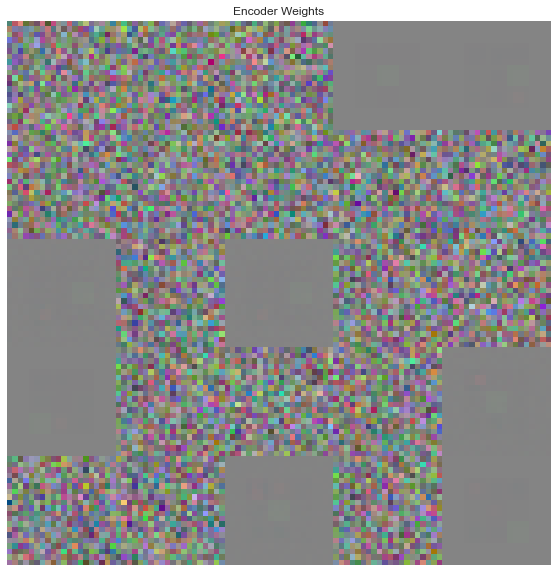

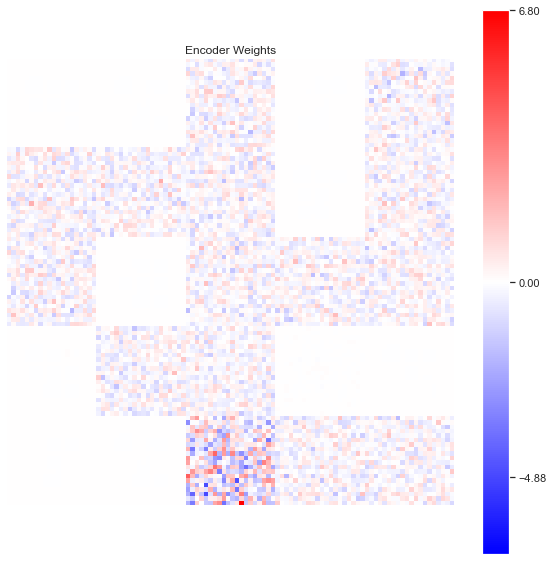

In [24]:
# Get weights
initial_weights = copy.deepcopy(list(agent.model.parameters())[0])
initial_weights.requires_grad = False
torch.nn.init.normal(initial_weights, 0, 1)

with torch.no_grad():
    new_weights = chu_train(obs_dataset, initial_weights, 1000, 1000, learning_rate=2e-2,
              anti_hebbian_learning_strength=0.6, lebesgue_norm=2.0, rank=2)
draw_colored_weights(new_weights, 5, 5, sz=IMG_SHAPE, text='Encoder Weights');
draw_weights(new_weights, 5, 5, sz=IMG_SHAPE[1], text='Encoder Weights');

In [ ]:
n_steps = 100000
print_freq = 1000

# Set encoder weight to learned weights and freeze them
encoder_weights = list(agent.model.parameters())[0]
with torch.no_grad():
    encoder_weights.data = new_weights.data
encoder_weights.requires_grad = False

train_task_model(agent, env, n_steps, print_freq=print_freq)

Step: 1000 | Episodes: 21 | Ep rewards: 0.5502
Step: 2000 | Episodes: 13 | Ep rewards: 0.3308
Step: 3000 | Episodes: 19 | Ep rewards: 0.4901
Step: 4000 | Episodes: 18 | Ep rewards: 0.4412
Step: 5000 | Episodes: 17 | Ep rewards: 0.4687
Step: 6000 | Episodes: 17 | Ep rewards: 0.4254
Step: 7000 | Episodes: 21 | Ep rewards: 0.5472
Step: 8000 | Episodes: 19 | Ep rewards: 0.5108
Step: 9000 | Episodes: 16 | Ep rewards: 0.3995
Step: 10000 | Episodes: 15 | Ep rewards: 0.3251


KeyboardInterrupt: 

In [8]:
per_run_steps = 50000
bin_size = 500
n_runs = 5
seed = 0

## Standard RL Test

Setting random seed to 0


  0%|          | 0/5 [00:00<?, ?it/s]e:\projects\continual_backprop\rl_representation\src\agents\dqn.py:111: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch_data = [torch.tensor(e, dtype=torch.float32, device=self.device) \
100%|██████████| 5/5 [1:26:02<00:00, 1032.48s/it]


Text(0, 0.5, 'Avg. Episode Reward')

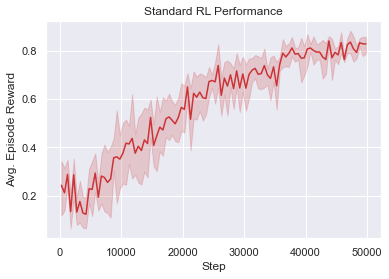

In [235]:
# Set encoder weight to learned weights and freeze them
reset_rand_seed(seed)
results = run_benchmark(
    env, create_agent=create_agent,
    n_steps=per_run_steps, n_runs=n_runs)
df = generate_plot_data(*results, bin_size)
sns.lineplot(data=df, x='x', y='y', ci=95)
plt.title('Standard RL Performance')
plt.xlabel('Step')
plt.ylabel('Avg. Episode Reward')

## Random Encoder Test

Setting random seed to 0


  0%|          | 0/5 [00:00<?, ?it/s]e:\projects\continual_backprop\rl_representation\src\agents\dqn.py:111: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch_data = [torch.tensor(e, dtype=torch.float32, device=self.device) \
100%|██████████| 5/5 [1:25:59<00:00, 1031.82s/it]


Text(0, 0.5, 'Avg. Episode Reward')

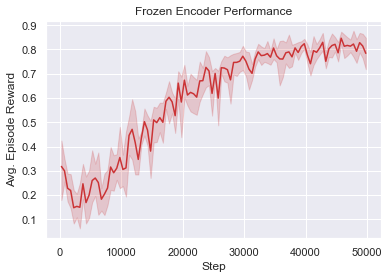

In [236]:
# Set encoder weight to learned weights and freeze them
def create_frozen_enc_agent():
    agent = create_agent()
    encoder_weights = list(agent.model.parameters())[0]
    encoder_weights.requires_grad = False
    return agent

# Set encoder weight to learned weights and freeze them
reset_rand_seed(seed)
results = run_benchmark(
    env, create_agent=create_frozen_enc_agent,
    n_steps=per_run_steps, n_runs=n_runs)
df = generate_plot_data(*results, bin_size)
sns.lineplot(data=df, x='x', y='y', ci=95)
plt.title('Frozen Encoder Performance')
plt.xlabel('Step')
plt.ylabel('Avg. Episode Reward')

## Competing Hidden Units Test

Setting random seed to 0


  0%|          | 0/5 [00:00<?, ?it/s]e:\projects\continual_backprop\rl_representation\src\agents\dqn.py:111: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch_data = [torch.tensor(e, dtype=torch.float32, device=self.device) \
100%|██████████| 5/5 [1:26:29<00:00, 1037.93s/it]


Setting random seed to 0


  0%|          | 0/5 [00:00<?, ?it/s]e:\projects\continual_backprop\rl_representation\src\agents\dqn.py:111: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch_data = [torch.tensor(e, dtype=torch.float32, device=self.device) \
100%|██████████| 5/5 [1:26:01<00:00, 1032.22s/it]


Setting random seed to 0


  0%|          | 0/5 [00:00<?, ?it/s]e:\projects\continual_backprop\rl_representation\src\agents\dqn.py:111: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch_data = [torch.tensor(e, dtype=torch.float32, device=self.device) \
100%|██████████| 5/5 [1:28:40<00:00, 1064.14s/it]


Setting random seed to 0


  0%|          | 0/5 [00:00<?, ?it/s]e:\projects\continual_backprop\rl_representation\src\agents\dqn.py:111: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch_data = [torch.tensor(e, dtype=torch.float32, device=self.device) \
100%|██████████| 5/5 [1:39:21<00:00, 1192.29s/it]


Setting random seed to 0


  0%|          | 0/5 [00:00<?, ?it/s]e:\projects\continual_backprop\rl_representation\src\agents\dqn.py:111: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch_data = [torch.tensor(e, dtype=torch.float32, device=self.device) \
100%|██████████| 5/5 [1:33:08<00:00, 1117.64s/it]


Setting random seed to 0


  0%|          | 0/5 [00:00<?, ?it/s]e:\projects\continual_backprop\rl_representation\src\agents\dqn.py:111: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch_data = [torch.tensor(e, dtype=torch.float32, device=self.device) \
100%|██████████| 5/5 [1:34:57<00:00, 1139.45s/it]


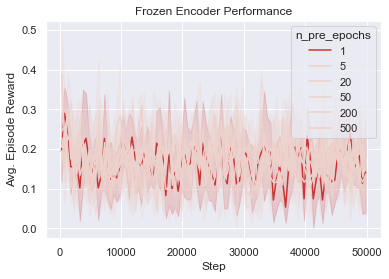

In [237]:
def create_pretrained_agent(episodes):
    agent = create_agent()
    encoder_weights = list(agent.model.parameters())[0]
    encoder_weights.requires_grad = False
    encoder_weights = chu_train(obs_dataset, encoder_weights, episodes, 500)
    return agent

pretrain_epochs = [1, 5, 20, 50, 200, 500]
all_results = []
for n_epochs in pretrain_epochs:
    reset_rand_seed(seed)
    results = run_benchmark(
        env, create_agent=lambda: create_pretrained_agent(n_epochs),
        n_steps=per_run_steps, n_runs=n_runs)
    all_results.append(results)
    df = generate_plot_data(*results, bin_size)
    df['n_pre_epochs'] = n_epochs
    sns.lineplot(data=df, x='x', y='y', hue='n_pre_epochs', ci=95)
    plt.title('Frozen Encoder Performance')
    plt.xlabel('Step')
    plt.ylabel('Avg. Episode Reward')
    plt.plot()

AttributeError: 'Figure' object has no attribute 'plot'

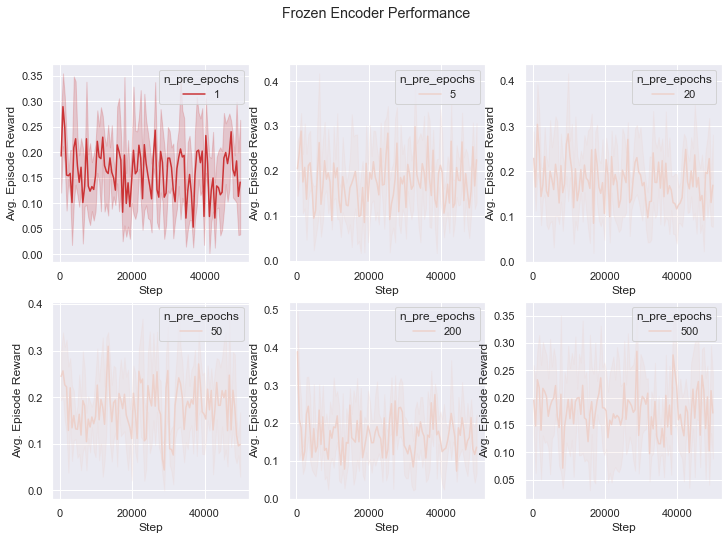

In [240]:
fig, axs = plt.subplots(2, 3, figsize=(12, 8))
for i, (results, n_epochs) in enumerate(zip(all_results, pretrain_epochs)):
    df = generate_plot_data(*results, bin_size)
    df['n_pre_epochs'] = n_epochs
    sns.lineplot(data=df, x='x', y='y', hue='n_pre_epochs', ci=95, ax=axs[i//3, i%3])
    axs[i//3, i%3].set_xlabel('Step')
    axs[i//3, i%3].set_ylabel('Avg. Episode Reward')

fig.suptitle('Frozen Encoder Performance')
fig.plot()

# Testing the agent

In [10]:
base_reward = test_agent(agent, env, n_episodes=30)
print(f'Base agent reward: {base_reward:.2f}')

Base agent reward: 0.94


# Testing agent performance with color shifts

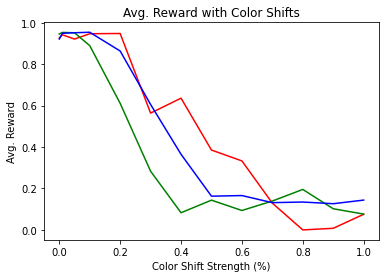

In [11]:
strengths = [0, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
colors = {
    'r': (1, 0, 0),
    'g': (0, 1, 0),
    'b': (0, 0, 1)}

for color, rgb in colors.items():
    performance = []
    for strength in strengths:
        filter_env = make_env(color_shift=rgb, shift_strength=strength)
        filter_reward = test_agent(agent, filter_env, n_episodes=30)
        performance.append(filter_reward)

    # plot with red line color
    plt.plot(strengths, performance, color)

plt.title('Avg. Reward with Color Shifts')
plt.xlabel('Color Shift Strength (%)')
plt.ylabel('Avg. Reward');


## Remaining Tasks
- Create an activation function that zeros out certain nodes
- Get a mapping of the gradients for each nodes after many steps on the transfer task
- Make a function that makes a activation function mask for nodes within a certain percentile
- Try dropping those weights
- Try dropping nodes that meet a threshold number of outgoing weights dropped

In [12]:
def freeze_agent(agent):
    for param in agent.model.parameters():
        param.requires_grad = False
    for param in agent.target_model.parameters():
        param.requires_grad = False

def unfreeze_agent(agent):
    for param in agent.model.parameters():
        param.requires_grad = True
    for param in agent.target_model.parameters():
        param.requires_grad = True

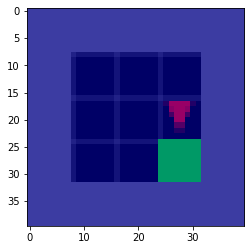

In [13]:
filter_env = make_env(color_shift=(0, 0, 1,), shift_strength=0.4)
plt.imshow(filter_env.reset().transpose(1, 2, 0))
transfer_agent = rl.agents.DDDQNAgent(filter_env, copy.deepcopy(agent.model), log_freq=-1, learning_start=int(1e9))

In [14]:
# Generate data
steps = 10000
train_task_model(transfer_agent, filter_env, steps, print_freq=print_freq*5)

Step: 5000 | Episodes: 87 | Ep rewards: 0.4403


In [87]:
# Get gradient errors on the transfer problem
transfer_agent.optimizer.zero_grad()
grad_steps = 50
grad_sums = [torch.zeros_like(p) for p in transfer_agent.model.parameters()]
for _ in range(grad_steps):
    transfer_agent.calculate_losses().mean().backward()
    for i, param in enumerate(transfer_agent.model.parameters()):
        grad_sums[i] += torch.abs(param.grad)
        # print(torch.sum(param.grad != 0) / param.numel())
        # break
    transfer_agent.optimizer.zero_grad()

e:\projects\continual_backprop\rl_representation\src\agents\dqn.py:111: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch_data = [torch.tensor(e, dtype=torch.float32, device=self.device) \


In [68]:
# param = list(transfer_agent.model.parameters())[0]
# torch.sum(param == 0) / param.numel()
# torch.sum(grad_sums[0] != 0) / grad_sums[0].numel()

In [92]:
backup_ta = copy.deepcopy(transfer_agent)
reset_frac = 0.001
for i, (grads, param) in enumerate(zip(grad_sums, transfer_agent.model.parameters())):
    if i != len(grad_sums) - 2:
        continue
    reset_threshold = torch.quantile(grads, 1-reset_frac)
    reset_threshold = max(reset_threshold, 1e-5)
    mask = grads < reset_threshold
    print('Param #{}, {:.2f}% removed'.format(i, 100 - (mask.sum().item() / mask.numel() * 100)))
    with torch.no_grad():
        param *= mask.float()

Param #10, 0.11% removed


In [134]:
for p1, p2 in zip(backup_ta.model.parameters(), transfer_agent.model.parameters()):
    print('Differences:', torch.sum(p1 != p2).item())
print('Non-zero grad frac:', (grad_sums[-2].count_nonzero() / grad_sums[-2].numel()).item())

Differences: 0
Differences: 0
Differences: 0
Differences: 0
Differences: 0
Differences: 0
Differences: 0
Differences: 0
Differences: 0
Differences: 0
Differences: 0
Differences: 0
Non-zero grad frac: 0.8504464626312256


In [15]:
removed_hidden_units = set([])
target_layer = list(transfer_agent.model.parameters())[-1]

for i in range(target_layer.shape[1]):
    print('\nPruning iteration #{}'.format(i+1))
    base_reward = test_agent(transfer_agent, filter_env, n_episodes=100)
    print(f'Base agent reward: {base_reward:.2f}')
    hidden_rewards = []
    for input_idx in range(target_layer.shape[1]):
        if input_idx in removed_hidden_units:
            hidden_rewards.append(-1)
        else:
            with torch.no_grad():
                old_vals = target_layer[:, input_idx]
                target_layer[:, input_idx] = 0
                reward = test_agent(transfer_agent, filter_env, n_episodes=50)
                hidden_rewards.append(reward)
                print('Hidden unit {}: {:.2f}'.format(input_idx, reward))
                target_layer[:, input_idx] = old_vals
    max_idx = np.argmax(hidden_rewards)
    if hidden_rewards[max_idx] > base_reward * 1.1:
        print('Removing hidden unit {}'.format(max_idx))
        with torch.no_grad():
            target_layer[:, max_idx] = 0
        removed_hidden_units.add(max_idx)
    else:
        break


Pruning iteration #1
Base agent reward: 0.48
Hidden unit 0: 0.42
Hidden unit 1: 0.27
Hidden unit 2: 0.21
Hidden unit 3: 0.40
Hidden unit 4: 0.21
Hidden unit 5: 0.35
Hidden unit 6: 0.47
Hidden unit 7: 0.38
Hidden unit 8: 0.40
Hidden unit 9: 0.34
Hidden unit 10: 0.35
Hidden unit 11: 0.47
Hidden unit 12: 0.32
Hidden unit 13: 0.50
Hidden unit 14: 0.34
Hidden unit 15: 0.23
Hidden unit 16: 0.39
Hidden unit 17: 0.40
Hidden unit 18: 0.38
Hidden unit 19: 0.45
Hidden unit 20: 0.28
Hidden unit 21: 0.24
Hidden unit 22: 0.34
Hidden unit 23: 0.30
Hidden unit 24: 0.30
Hidden unit 25: 0.44
Hidden unit 26: 0.21
Hidden unit 27: 0.38
Hidden unit 28: 0.48
Hidden unit 29: 0.42
Hidden unit 30: 0.32
Hidden unit 31: 0.14
Hidden unit 32: 0.26
Hidden unit 33: 0.44
Hidden unit 34: 0.23
Hidden unit 35: 0.19
Hidden unit 36: 0.25
Hidden unit 37: 0.19
Hidden unit 38: 0.27
Hidden unit 39: 0.10
Hidden unit 40: 0.10
Hidden unit 41: 0.08
Hidden unit 42: 0.13
Hidden unit 43: 0.14
Hidden unit 44: 0.07
Hidden unit 45: 0.1

In [109]:
base_reward = test_agent(transfer_agent, filter_env, n_episodes=10)
print(f'Transfer agent reward: {base_reward:.2f}')

Transfer agent reward: 0.49


In [101]:
transfer_agent = copy.deepcopy(backup_ta)